In [32]:
import os
import random
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [33]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [34]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [35]:
anno = pd.read_csv(annotation_csv)

In [27]:
anno.columns

Index(['scene', 'sample', 'action', 'category', 'fl_x', 'fr_x', 'bl_x', 'br_x',
       'fl_y', 'fr_y', 'bl_y', 'br_y', 'category_id', 'action_id',
       'new_scene'],
      dtype='object')

In [6]:
example = anno[anno['category_id'] == 8]

In [7]:
example.head()

,scene,sample,action,category,fl_x,fr_x,bl_x,br_x,fl_y,fr_y,bl_y,br_y,category_id,action_id,new_scene
24453,107,14,object_action_walking,animal,14.013089,13.999948,13.427134,13.413992,10.383758,10.161247,10.418172,10.195660,8,2,107
24457,107,15,object_action_walking,animal,13.068930,13.055947,12.482934,12.469951,10.428298,10.205801,10.462345,10.239848,8,2,107
24461,107,16,object_action_walking,animal,12.214721,12.202064,11.628682,11.616025,10.443321,10.220789,10.476491,10.253959,8,2,107
24474,107,18,object_action_walking,animal,10.618526,10.606740,10.032358,10.020571,10.529322,10.306759,10.560208,10.337645,8,2,107
24476,107,19,object_action_walking,animal,9.932528,9.921125,9.346304,9.334901,10.582343,10.359749,10.612246,10.389652,8,2,107


In [8]:
xs = example.iloc[20, 4:8]
ys = example.iloc[20, 8:12]

abs(abs(max(xs)) - abs(min(xs)))/abs(abs(max(ys)) - abs(min(ys)))

0.38178783989833376

In [9]:
# 'other_vehicle': 0,
# 'bicycle': 1,
# 'car': 2,
# 'pedestrian': 3,
# 'truck': 4,
# 'bus': 5,
# 'motorcycle': 6,
# 'emergency_vehicle': 7,
# 'animal': 8

In [4]:
labeled_scene_index = np.arange(106, 134)

transform = torchvision.transforms.ToTensor()

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [5]:
sample_cat, sample, target, road_image, extra = iter(trainloader).next()

In [7]:
print(torch.stack(sample_cat).shape)

torch.Size([2, 3, 1536, 306])


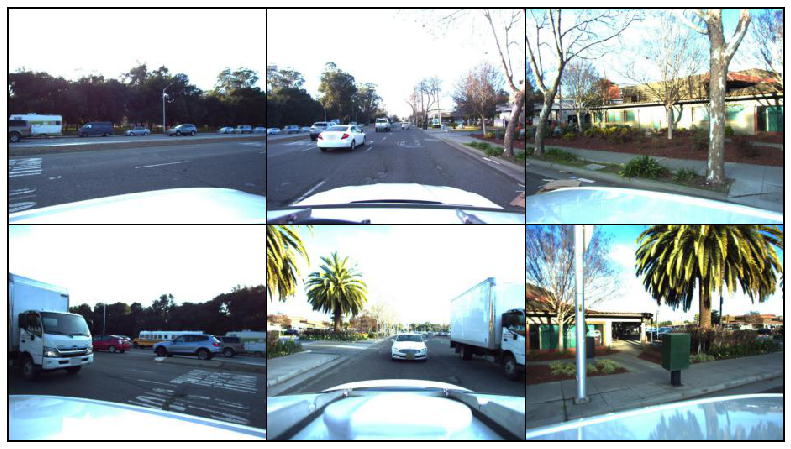

In [13]:
plt.figure(figsize=(20,8))
plt.imshow(torchvision.utils.make_grid(torch.stack(sample)[0], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

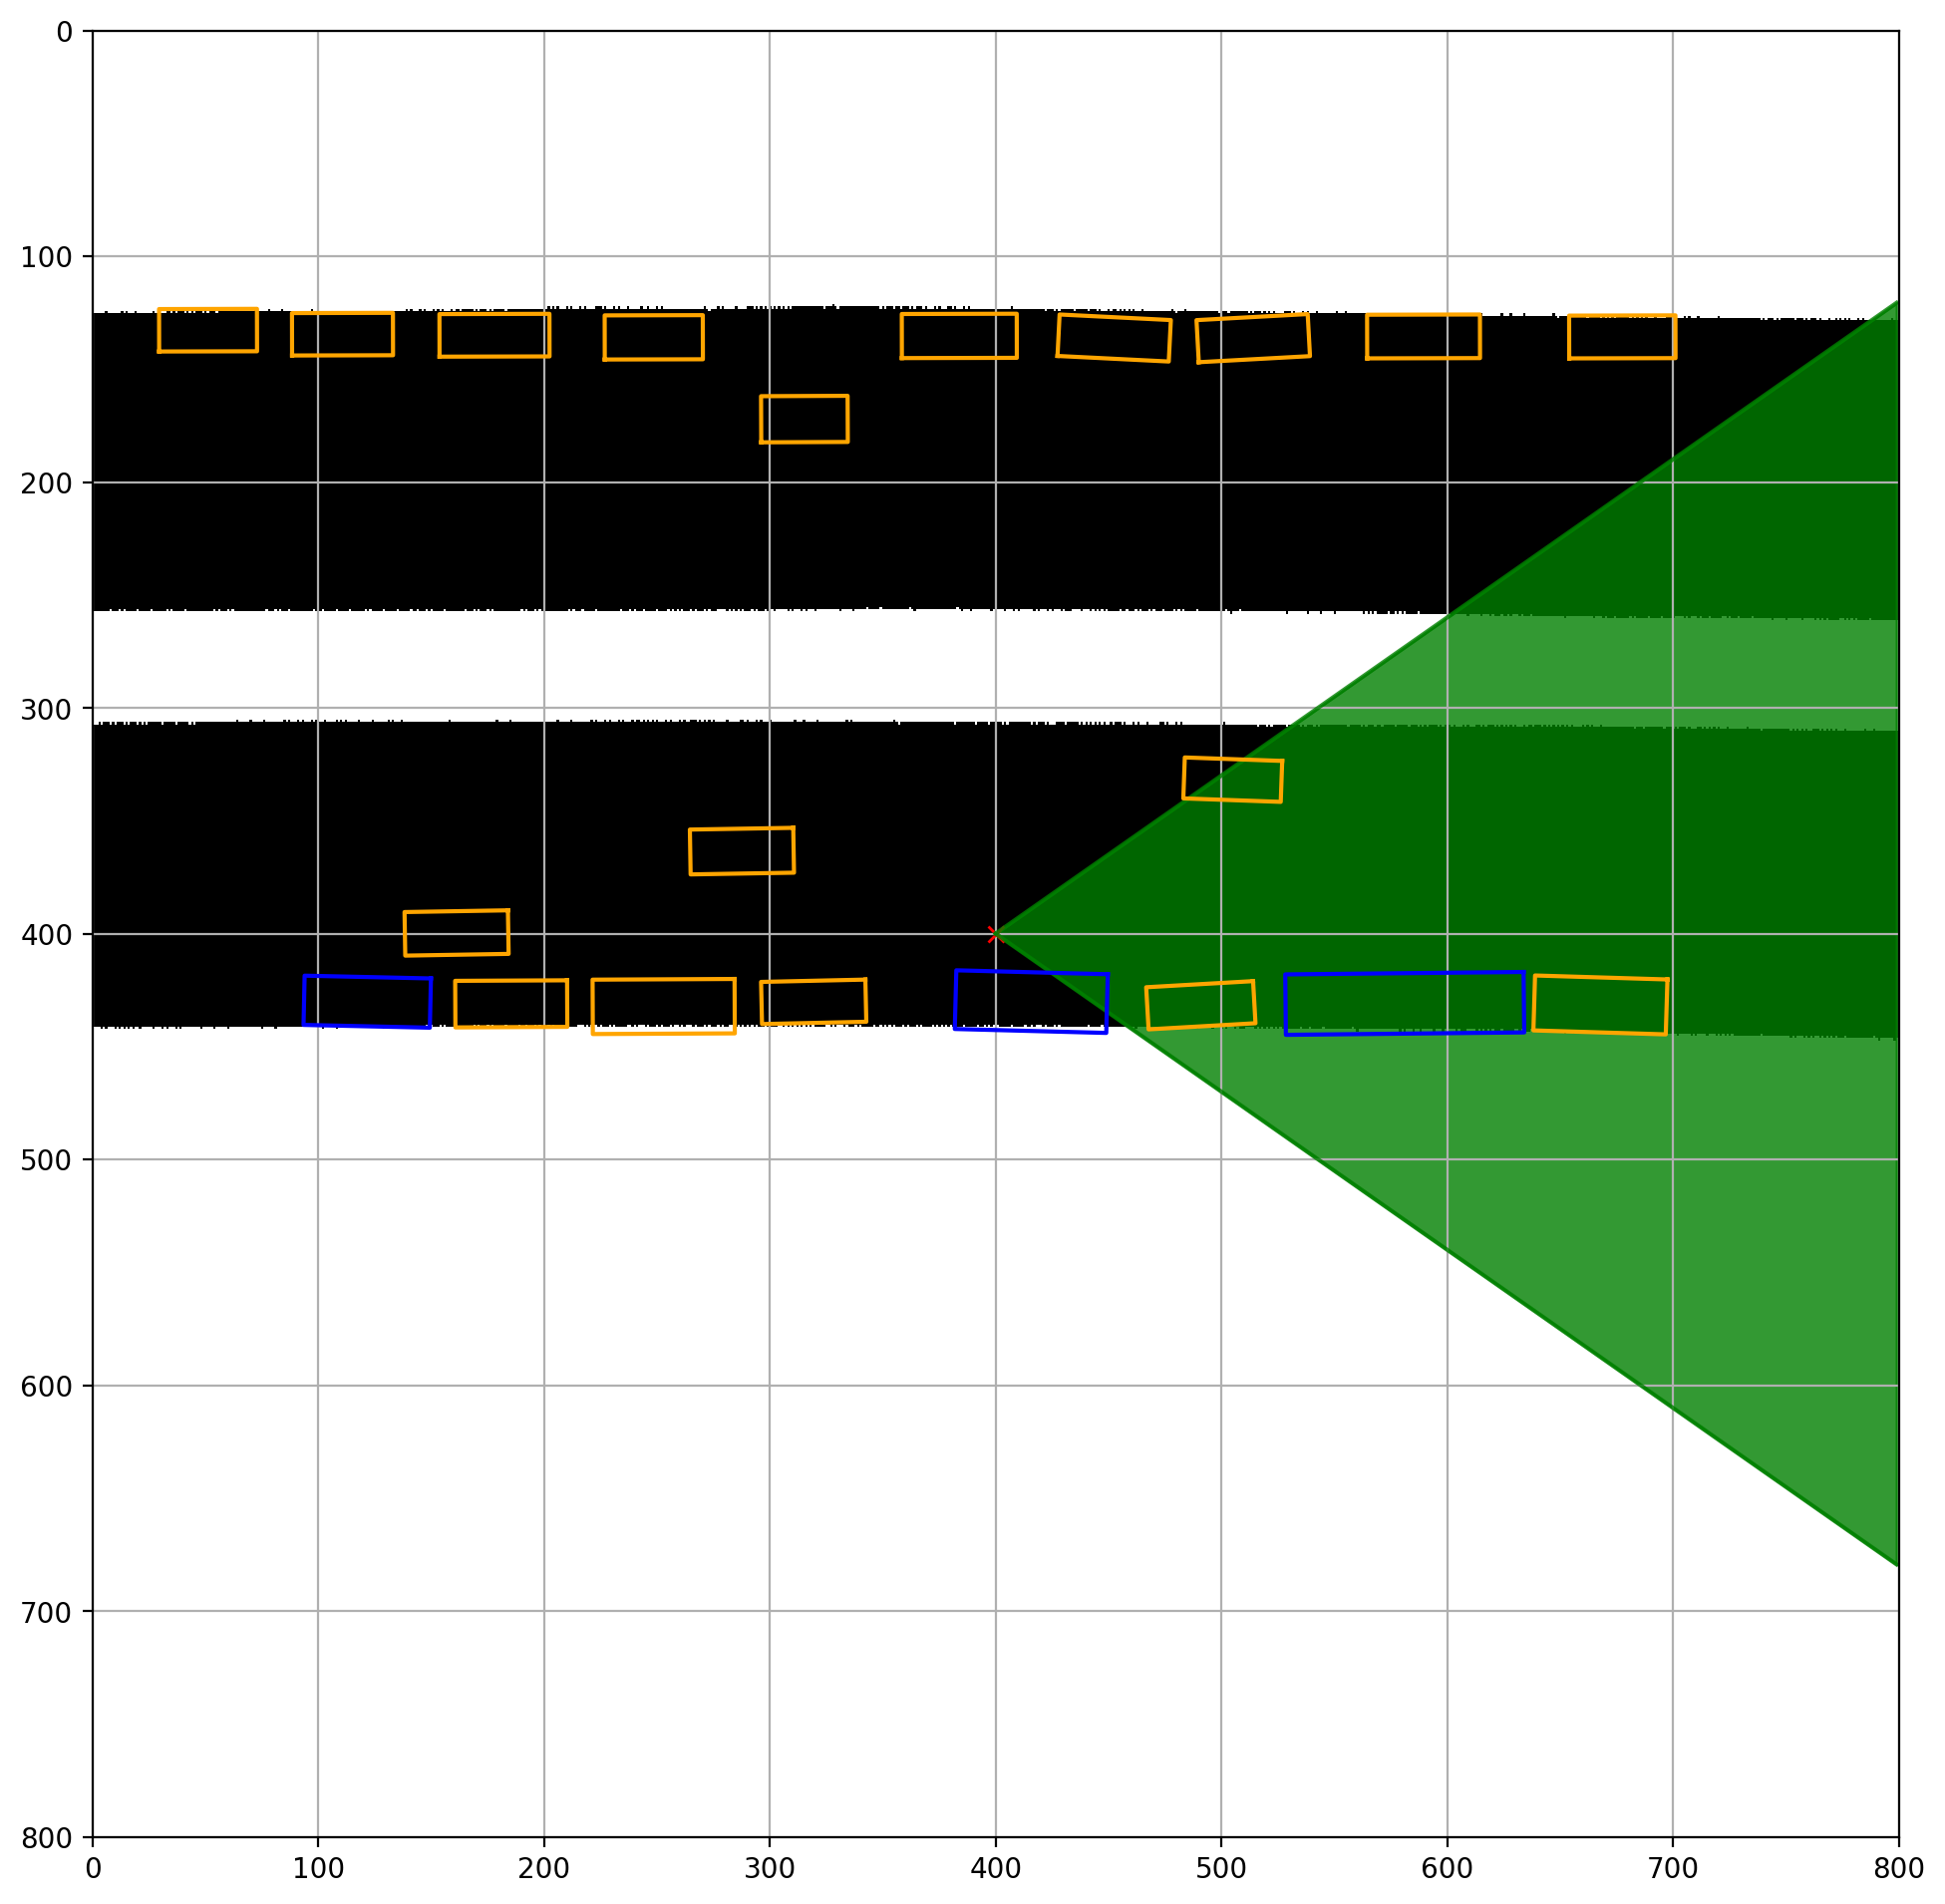

In [12]:
# The center of image is 400 * 400

fig, ax = plt.subplots(figsize=(12,12))



color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']



ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

x = np.arange(400, 800)
y1 = 400 - math.tan(math.pi*(35/180))*(x-400)
y2 = 400 + math.tan(math.pi*(35/180))*(x-400)
ax.plot(x, y1, color = 'green', alpha = 0.8)
ax.plot(x, y2, color = 'green', alpha = 0.8)
ax.fill_between(x, y1, y2, color = 'green', alpha = 0.8)
ax.set_xlim([0, 800])
ax.set_ylim([800, 0])


for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])   
    
ax.grid()

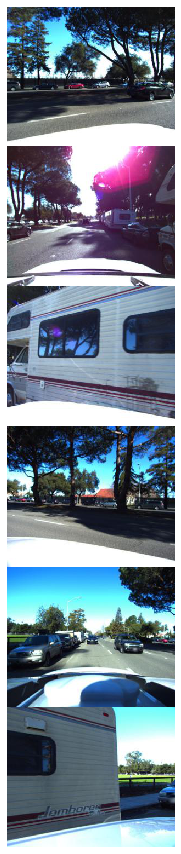

In [18]:
plt.figure(figsize=(3,18))
plt.imshow(torchvision.utils.make_grid(torch.stack(sample_cat)[0], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

# Define Sample

In [7]:
labeled_scene_index = np.arange(107, 134)

transform = torchvision.transforms.ToTensor()

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=15, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [9]:
sample_cat,sample, target, road_image, extra = iter(trainloader).next()

In [10]:
# road_image[0]

# Redo Plot draw_box

In [11]:
def draw_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    ax.plot(point_squence.T[0], point_squence.T[1], color=color)

# Range Plot

In [12]:
bounds = [(95, 25), (35, -35), (-25, -95), (155, 85), (-145, 145), (-85, -155)]
bounds_coef = [(math.tan(math.pi*(y1/180)), math.tan(math.pi*(y2/180))) for (y1, y2) in bounds]
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
camera_name = ['front_left', 'front', 'front_right', 'back_left', 'back', 'back_right']

In [13]:
def plot_range(sample_index):
    
    fig, ax = plt.subplots(nrows=6, ncols=2,figsize=(15,45))

    for i in range(6):
        ax[i, 0].imshow(torchvision.utils.make_grid(torch.stack(sample)[sample_index][i], nrow=3).numpy().transpose(1, 2, 0))
        ax[i, 0].axis('off')
            
        ax[i, 1].imshow(road_image[sample_index], cmap='binary', extent=[-40,40,-40,40])
        
        if abs(bounds[i][0]) > 90: 
            x1 = np.arange(0, -40, -1)
        else:
            x1 = np.arange(0, 40)
            
        if abs(bounds[i][1]) > 90: 
            x2 = np.arange(0, -40, -1)
        else:
            x2 = np.arange(0, 40)

        ax[i, 1].scatter(0, 0, c = 'r', marker = 'x')

        y1 = bounds_coef[i][0] * x1
        y2 = bounds_coef[i][1] * x2
        
        
        ax[i, 1].plot(x1, y1, color = 'green', alpha = 0.5)
        ax[i, 1].plot(x2, y2, color = 'green', alpha = 0.5)
        
        if x1[1] == x2[1]:
            ax[i, 1].fill_between(x1, y1, y2, color = 'green', alpha = 0.5)
        else:
            ax[i, 1].fill_between(x1, y1, np.sign(y1[1])*40, color = 'green', alpha = 0.5)
            ax[i, 1].fill_between(x2, y2, np.sign(y2[1])*40, color = 'green', alpha = 0.5)
            
        
        ax[i, 1].set_xlim([-40, 40])
        ax[i, 1].set_ylim([-40, 40])
        ax[i, 1].grid()
        
        for j, bb in enumerate(target[sample_index]['bounding_box']):
            draw_box(ax[i, 1], bb, color=color_list[target[sample_index]['category'][j]])   
             
        

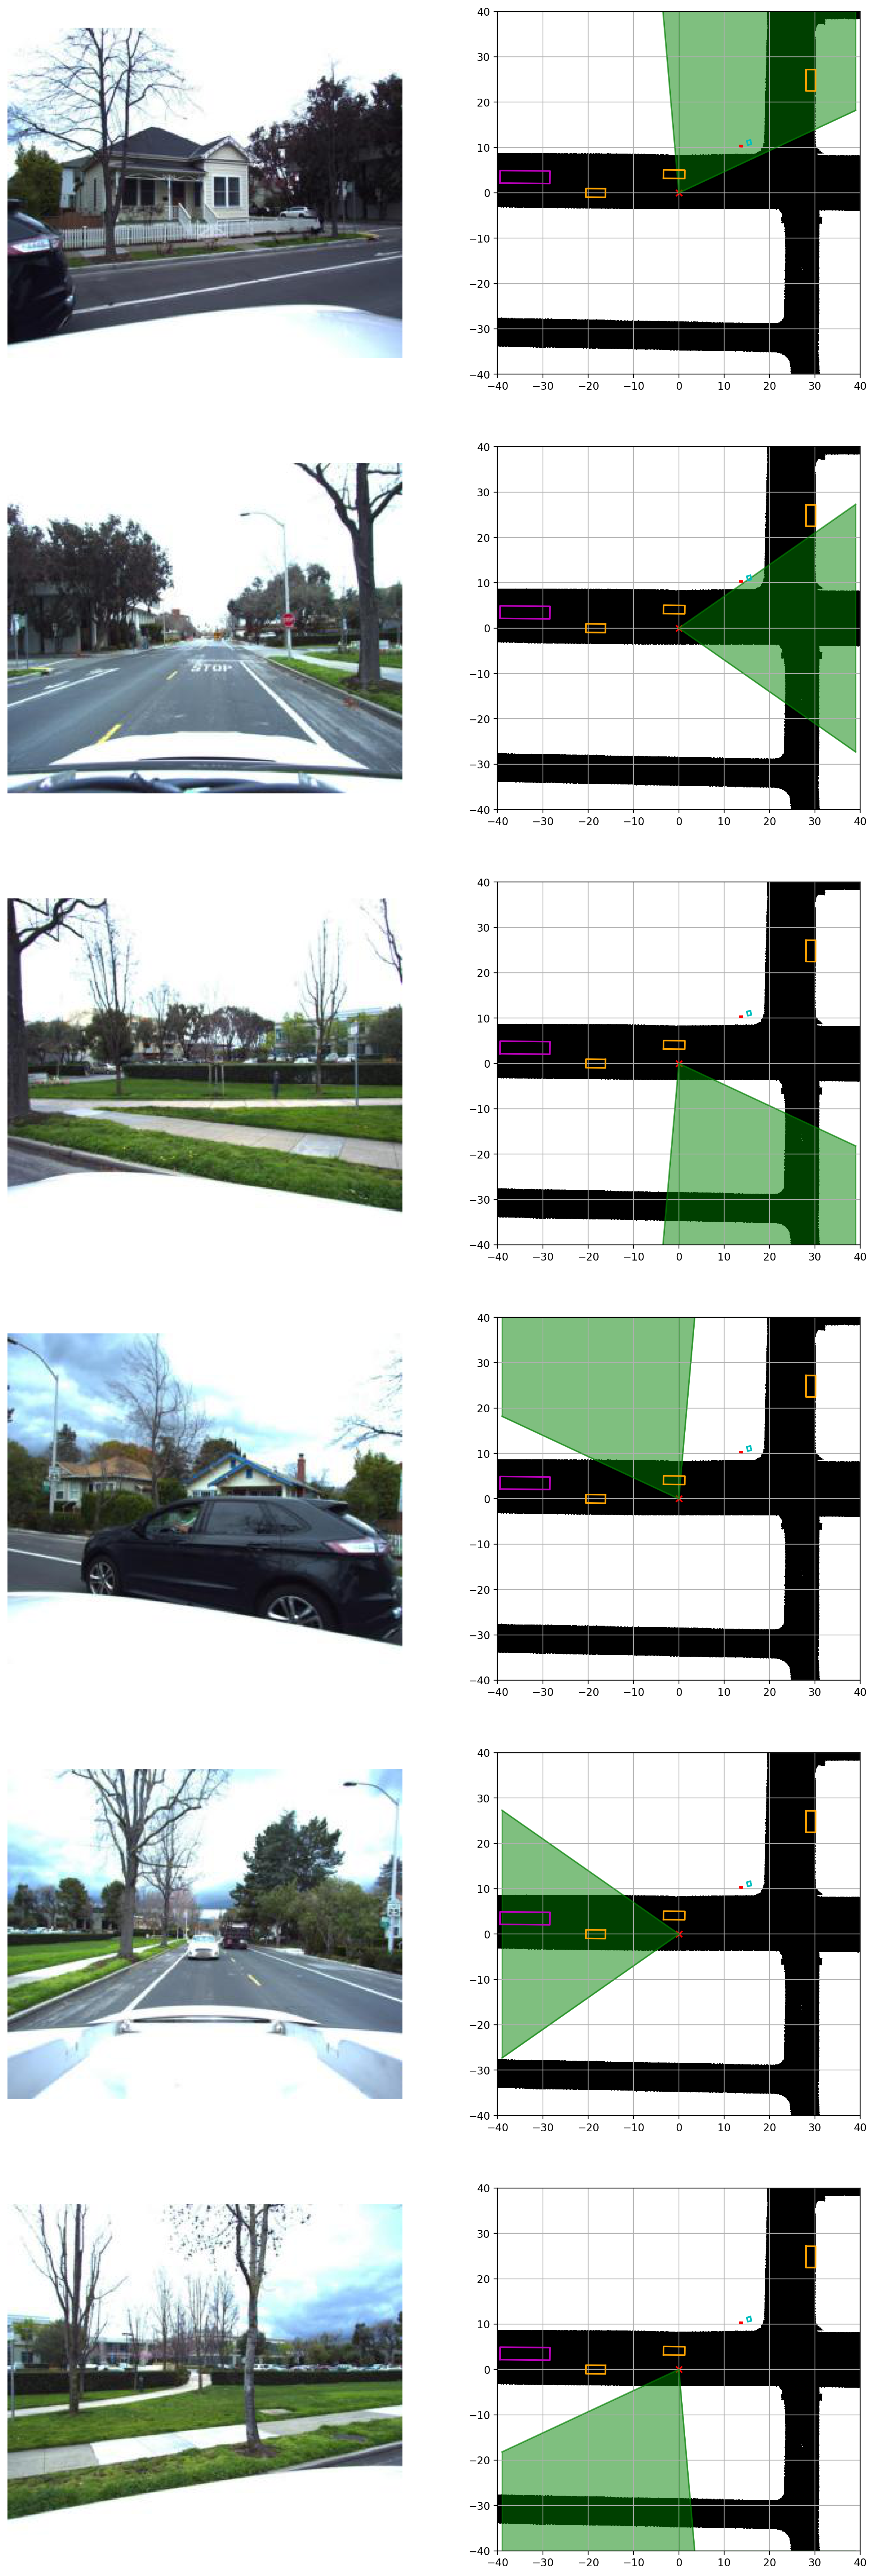

In [14]:
plot_range(14)

# Feature - Which Camera

In [354]:
anno[anno['scene'] == 106][anno['sample'] == 0]

/Users/mjin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,scene,sample,action,category,fl_x,fr_x,bl_x,br_x,fl_y,fr_y,bl_y,br_y,category_id,action_id,new_scene
3583,106,0,object_action_parked,other_vehicle,4.967384,4.899423,-1.740261,-1.808222,-1.798935,-4.397982,-1.624528,-4.223574,0,0,106
3584,106,0,object_action_parked,other_vehicle,23.381680,23.408801,12.827323,12.854444,-1.698497,-4.375250,-1.806678,-4.483432,0,0,106
3585,106,0,object_action_driving_straight_forward,car,-10.379461,-10.388055,-6.546532,-6.555126,21.758967,23.802104,21.775561,23.818698,2,1,106
3586,106,0,object_action_parked,car,16.455485,16.451223,21.452425,21.448162,25.477589,27.409785,25.489233,27.421430,2,0,106
3587,106,0,object_action_parked,car,-37.043864,-37.048009,-32.708916,-32.713061,25.781453,27.660672,25.791555,27.670773,2,0,106
3588,106,0,object_action_parked,car,2.741086,2.833281,7.667835,7.760030,25.584643,27.420583,25.338056,27.173997,2,0,106
3589,106,0,object_action_parked,car,29.751956,29.678456,23.889687,23.816187,-2.030478,-4.462372,-1.854182,-4.286076,2,0,106
3590,106,0,object_action_parked,car,-5.768138,-5.726751,-10.386960,-10.345573,-2.036250,-3.903015,-2.139151,-4.005916,2,0,106
3591,106,0,object_action_parked,car,-17.309486,-17.313796,-12.963538,-12.967849,25.427290,27.381477,25.437417,27.391605,2,0,106
3592,106,0,object_action_parked,car,-18.978175,-18.968470,-23.934073,-23.924368,-2.067754,-4.129878,-2.091685,-4.153809,2,0,106


In [357]:
bounds_quat = [[3,1], [1,4], [4,3], [2,1], [3,2], [4,3]]

In [436]:
def check_cam_index(index, camera_index):
    points = [(anno.iloc[index, 4+i], anno.iloc[index, 8+i]) for i in range(4)]
#     print(np.sign(points))
    for x, y in points:
        
        if np.sign(x) == 1 and np.sign(y) == 1:
            quat = 1
        elif np.sign(x) == 1 and np.sign(y) == -1:
            quat = 4
        elif np.sign(x) == -1 and np.sign(y) == 1:
            quat = 2
        else:
            quat = 3
            
        if quat not in bounds_quat[camera_index]:
            continue
            
        angle = math.atan(y/x)/math.pi*180
        
        if quat in [1,2] and angle < 0:
            angle += 180
        elif quat in [3,4] and angle > 0:
            angle -= 180
        
        if camera_index == 4:
            if abs(angle) > 145:
                return True
        else:
            if angle >= min(bounds[camera_index]) and angle <= max(bounds[camera_index]):
                return True
            
    
    return False

In [437]:
def check_cam_row(row, camera_index):
    points = [(row.iloc[4+i], row.iloc[8+i]) for i in range(4)]
#     print(np.sign(points))
    for x, y in points:
        
        if np.sign(x) == 1 and np.sign(y) == 1:
            quat = 1
        elif np.sign(x) == 1 and np.sign(y) == -1:
            quat = 4
        elif np.sign(x) == -1 and np.sign(y) == 1:
            quat = 2
        else:
            quat = 3
            
        if quat not in bounds_quat[camera_index]:
            continue
            
        angle = math.atan(y/x)/math.pi*180
        
        if quat in [1,2] and angle < 0:
            angle += 180
        elif quat in [3,4] and angle > 0:
            angle -= 180
        
        if camera_index == 4:
            if abs(angle) > 145:
                return True
        else:
            if angle >= min(bounds[camera_index]) and angle <= max(bounds[camera_index]):
                return True
            
    
    return False

In [438]:
for index, name in enumerate(camera_name):
    anno[name] = anno.apply(lambda x: check_cam_row(x, index), axis = 1)

In [439]:
anno.head()

,scene,sample,action,category,fl_x,fr_x,bl_x,br_x,fl_y,fr_y,...,br_y,category_id,action_id,new_scene,front_left,front,front_right,back_left,back,back_right
0,111,0,object_action_driving_straight_forward,car,-14.270185,-14.286638,-9.696476,-9.712929,19.254325,21.132901,...,21.173571,2,1,111,False,False,False,True,False,False
1,111,0,object_action_parked,car,-5.902891,-5.657694,-1.628863,-1.383666,29.164061,31.026680,...,30.464799,2,0,111,False,False,False,True,False,False
2,111,0,object_action_walking,pedestrian,37.068518,36.283792,37.300167,36.515442,-20.233128,-20.032588,...,-19.126877,3,2,111,False,True,True,False,False,False
3,111,0,object_action_driving_straight_forward,car,1.972478,1.988930,-2.744222,-2.727770,8.132214,6.253638,...,6.211696,2,1,111,True,False,False,True,False,False
4,111,0,object_action_driving_straight_forward,car,39.051316,39.067769,34.334616,34.351068,5.287296,3.408720,...,3.366778,2,1,111,False,True,False,False,False,False


# Feature - Distance

In [447]:
def get_distance(row):
    x = np.mean(row.iloc[4:8])
    y = np.mean(row.iloc[8:12])
    return np.sqrt(x**2 + y**2)

In [448]:
anno['distance'] = anno.apply(lambda x: get_distance(x), axis = 1)

In [449]:
anno.head()

,scene,sample,action,category,fl_x,fr_x,bl_x,br_x,fl_y,fr_y,...,category_id,action_id,new_scene,front_left,front,front_right,back_left,back,back_right,distance
0,111,0,object_action_driving_straight_forward,car,-14.270185,-14.286638,-9.696476,-9.712929,19.254325,21.132901,...,2,1,111,False,False,False,True,False,False,23.503215
1,111,0,object_action_parked,car,-5.902891,-5.657694,-1.628863,-1.383666,29.164061,31.026680,...,2,0,111,False,False,False,True,False,False,30.036207
2,111,0,object_action_walking,pedestrian,37.068518,36.283792,37.300167,36.515442,-20.233128,-20.032588,...,3,2,111,False,True,True,False,False,False,41.724720
3,111,0,object_action_driving_straight_forward,car,1.972478,1.988930,-2.744222,-2.727770,8.132214,6.253638,...,2,1,111,True,False,False,True,False,False,7.181891
4,111,0,object_action_driving_straight_forward,car,39.051316,39.067769,34.334616,34.351068,5.287296,3.408720,...,2,1,111,False,True,False,False,False,False,36.955389


In [471]:
idx = [i for i in range(road_image[0].size(0) -1, -1, -1)]
idx = torch.LongTensor(idx)
inverted_roadimage = road_image[0].index_select(0, idx)

In [24]:
road_image[0]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

# Look at COCO annotation

In [33]:
import json

In [36]:
# Reading the json as a dict
with open('instances_val2017.json') as json_data:
    data = json.load(json_data)

# using the from_dict load function. Note that the 'orient' parameter 
#is not using the default value (or it will give the same error than you had)
# We transpose the resulting df and set index column as its index to get this result
# pd.DataFrame.from_dict(data, orient='index').T.set_index('index')   

AttributeError: 'list' object has no attribute 'items'

In [15]:
# data

# Try Concat Images

In [25]:
a = torch.rand(6, 3, 10, 20)
# b = torch.rand(6, 3, 10, 20)

In [26]:
a.shape

torch.Size([6, 3, 10, 20])

In [54]:
c = torch.cat((a, b), 1)
c.shape

torch.Size([2, 12, 3, 100, 100])

In [4]:
labeled_scene_index = np.arange(106,108)

transform = torchvision.transforms.ToTensor()

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)


In [9]:
sample_cat, sample, target, road_image, extra = iter(trainloader).next()

In [15]:
print(torch.stack(sample_cat).shape)

torch.Size([2, 3, 1536, 306])


# Try tqdm

In [19]:
from tqdm.autonotebook import tqdm

In [25]:
progress_bar = tqdm(trainloader)
for iter, data in enumerate(progress_bar):
    print(iter)
    sample_cat, sample, target, road_image, extra = data
    print(torch.stack(sample_cat).shape)
    break

0
torch.Size([15, 3, 1536, 306])


In [41]:
trainloader

# Feature - weight/height/centerx/centery style annotation

In [60]:
def get_whxy(row):
    x = np.mean(row.iloc[4:8])
    y = np.mean(row.iloc[8:12])
    w = abs(max(row.iloc[4:8]) - min(row.iloc[4:8]))
    h = abs(max(row.iloc[8:12]) - min(row.iloc[8:12]))
    return np.array([x, y, w, h])

In [75]:
anno['center_x'], anno['center_y'], anno['box_width'], anno['box_height'] = np.array(anno.apply(lambda x: get_whxy(x), axis = 1).tolist()).T

In [76]:
anno.head()

,scene,sample,action,category,fl_x,fr_x,bl_x,br_x,fl_y,fr_y,bl_y,br_y,category_id,action_id,new_scene,center_x,center_y,box_width,box_height
0,111,0,object_action_driving_straight_forward,car,-14.270185,-14.286638,-9.696476,-9.712929,19.254325,21.132901,19.294995,21.173571,2,1,111,-11.991557,20.213948,4.590162,1.919246
1,111,0,object_action_parked,car,-5.902891,-5.657694,-1.628863,-1.383666,29.164061,31.026680,28.602180,30.464799,2,0,111,-3.643278,29.814430,4.519225,2.424500
2,111,0,object_action_walking,pedestrian,37.068518,36.283792,37.300167,36.515442,-20.233128,-20.032588,-19.327417,-19.126877,3,2,111,36.791980,-19.680002,1.016375,1.106252
3,111,0,object_action_driving_straight_forward,car,1.972478,1.988930,-2.744222,-2.727770,8.132214,6.253638,8.090272,6.211696,2,1,111,-0.377646,7.171955,4.733153,1.920518
4,111,0,object_action_driving_straight_forward,car,39.051316,39.067769,34.334616,34.351068,5.287296,3.408720,5.245354,3.366778,2,1,111,36.701192,4.327037,4.733153,1.920518


In [ ]:
progress_bar = tqdm(training_generator)
            for iter, data in enumerate(progress_bar):